In [13]:
from sunxspex.thermal import thermal_emission
from sunxspex import emission
import astropy.units as u
import numpy as np

from sherpa.astro.instrument import RSPModelPHA
from sherpa.astro.instrument import RSPModelNoPHA
from sherpa.astro.io import read_arf, read_rmf, read_pha
from sherpa.models import model
from sherpa.astro.instrument import Response1D
from sherpa.stats import Chi2, CStat, Cash

from sherpa.fit import Fit
from astropy.io import fits
import datetime

from sherpa.plot import *
from sherpa.astro.plot import DataPHAPlot

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['science','notebook','grid'])

# XSM Data

## Instrument Response

In [2]:
rmf = read_rmf('caldb/CH2xsmrspwitharea_open20191214v01.rsp')
effarea=np.loadtxt('caldb/xsm_onaxis_effective_area.txt')

# XSM Data Analysis

## Data Seletion

In [4]:
lc_file = 'xsm_data/20220328/calibrated/ch2_xsm_20220328_v1_level2.lc'
pha_file = 'xsm_data/20220328/calibrated/ch2_xsm_20220328_v1_level2.pha'

def xsm_gen_lc(spec_file,ene_lo,ene_hi):
    hdu1 = fits.open(spec_file)
    hdu=fits.BinTableHDU.from_columns(hdu1[1].columns)

    data=hdu.data

    time_xsm = (data['TSTART']+data['TSTOP'])/2.
    tbinsize=(data['TSTOP'][0]-data['TSTART'][0])
    
    exposure=data['EXPOSURE']
    
    ns=len(data)
    fluxlc = np.zeros(ns)
    countlc = np.zeros(ns)
    
    ene=np.arange(0,512)*0.033+0.5+0.033/2.0 # Midpoint energy of PI bins
    
    kev2erg=1.6021e-9
    cgs2si=0.001

    startch=int((ene_lo-0.5)/0.033)
    stopch=int((ene_hi-0.5)/0.033)


    for i in range(0,ns):
        spec = data['COUNTS'][i]/data['EXPOSURE'][i]
        spec_ene = spec*ene/effarea
        fluxlc[i] = np.sum(spec_ene[startch:stopch])*kev2erg*cgs2si
        countlc[i] = np.sum(spec[startch:stopch])
    
    ## Select only bins with atleast half exposure for tbinsize >=10
    if (tbinsize >= 10.0):
        ind=(exposure  > max(exposure)/2.0)
        time_xsm=time_xsm[ind]
        fluxlc=fluxlc[ind]
        countlc = countlc[ind]
        exposure=exposure[ind]


    nbins=int(86400.0/tbinsize)
    
    tday0=int(time_xsm[0]/86400.0)*86400.0
    t0=(time_xsm[0]-int((time_xsm[0]-tday0)/tbinsize)*tbinsize)
    alltime=np.arange(0,nbins)*tbinsize+t0
    allflux=np.empty(nbins)
    allflux[:]=np.nan
    allcount=np.empty(nbins)
    allcount[:]=np.nan

    for i,t in enumerate(time_xsm):
        tbin=int((t-tday0)/tbinsize)
        allflux[tbin]=fluxlc[i]
        allcount[tbin]=countlc[i]

    return alltime, allflux, allcount


ene_lo = 1.551 #keV
ene_hi = 12.408 #keV

# alltime, allflux, allcount = xsm_gen_lc('xsm_data/20210908/calibrated/ch2_xsm_20210908_v1_level2.pha',ene_lo,ene_hi)
alltime, allflux, allcount = xsm_gen_lc(pha_file,ene_lo,ene_hi)
alltime = alltime - alltime.min()

### [Solar Flare M4.0](https://www.solarmonitor.org/goes_pop.php?date=20220328&type=xray)

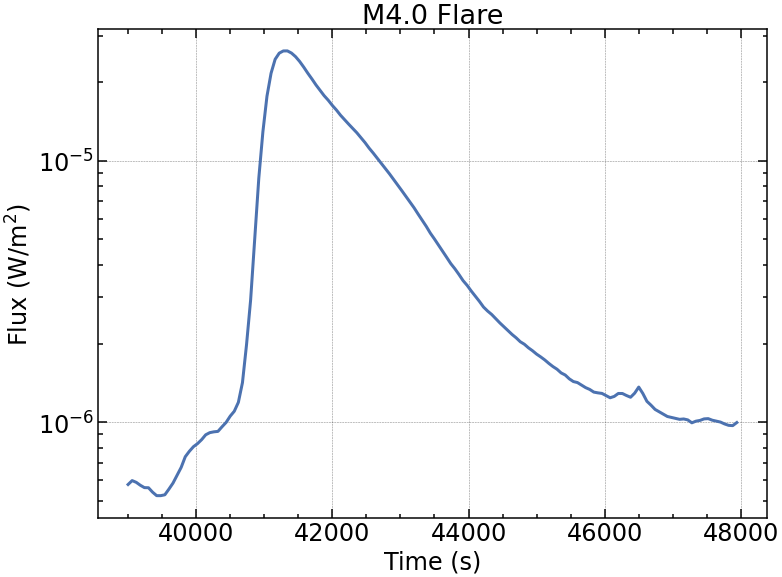

In [5]:
fig, ax = plt.subplots()
ax.semilogy(alltime[650:800],allflux[650:800])
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.set_title('M4.0 Flare');

In [6]:
alltime, allflux_1_3, allcount = xsm_gen_lc(pha_file,1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc(pha_file,3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc(pha_file,6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc(pha_file,10,15)
alltime = alltime - alltime.min()

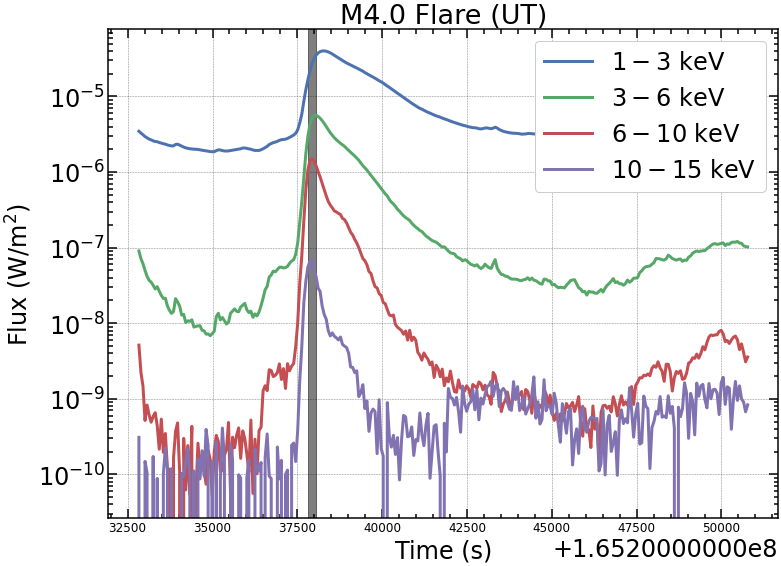

In [7]:
alltime, allflux_1_3, allcount = xsm_gen_lc(pha_file,1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc(pha_file,3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc(pha_file,6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc(pha_file,10,15)
# alltime = alltime - alltime.min()
fig, ax = plt.subplots()
ax.semilogy(alltime[600:900],allflux_1_3[600:900],label=r'$1 - 3$ keV')
ax.semilogy(alltime[600:900],allflux_3_6[600:900],label=r'$3 - 6$ keV')
ax.semilogy(alltime[600:900],allflux_6_10[600:900],label=r'$6 - 10$ keV')
ax.semilogy(alltime[600:900],allflux_10_15[600:900],label=r'$10 - 15$ keV')
ax.axvspan(alltime[683],alltime[687],alpha=0.5, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.legend()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('M4.0 Flare (UT)');

In [8]:
def xsm_genspec(spec_file,tstart,tstop,outfile): # times in seconds since 2017,1,1
    tref = datetime.datetime(2017, 1, 1, 0, 0)
    hdu1 = fits.open(spec_file)
    hdu=fits.BinTableHDU.from_columns(hdu1[1].columns)

    data=hdu.data

    time_xsm = (data['TSTART']+data['TSTOP'])/2.
    tbinsize=(data['TSTOP'][0]-data['TSTART'][0])
    
    exposure=data['EXPOSURE']

    inds = (time_xsm >= tstart) & (time_xsm <= tstop)

    data_f = data[inds]

    channel = data_f[0][1]
    spec_data = np.zeros(512)
    stat_err = np.zeros(512)
    sys_err = np.zeros(512)
    exposure = 0

    for di in data_f:
        spec_data = spec_data + di[2]
        stat_err = stat_err + di[3]
        sys_err = sys_err + di[4]
        exposure = exposure + di[5]

    # writing file
    hdu_list = []
    primary_hdu = fits.PrimaryHDU()
                                    
    hdu_list.append(primary_hdu)

    fits_columns = []
    col1 = fits.Column(name='CHANNEL',format='J',array=channel)
    col2 = fits.Column(name='COUNTS',format='E',array=spec_data)
    col3 = fits.Column(name='STAT_ERR',format='E',array=stat_err)
    col4 = fits.Column(name='SYS_ERR',format='E',array=sys_err)

    fits_columns.append(col1)
    fits_columns.append(col2)
    fits_columns.append(col3)
    fits_columns.append(col4)

    hdu_pha = fits.BinTableHDU.from_columns(fits.ColDefs(fits_columns))
    hdu_pha.name = 'SPECTRUM'
                                                                       
    hdu_list.append(hdu_pha)
                                                                       
    _hdu_list = fits.HDUList(hdus=hdu_list)

    tstart_dt = datetime.datetime.fromtimestamp(tstart+tref.timestamp())
    tstop_dt = datetime.datetime.fromtimestamp(tstop+tref.timestamp())

    _hdu_list[1].header.set('TSTART',tstart_dt.isoformat())
    _hdu_list[1].header.set('TSTOP',tstop_dt.isoformat())
    _hdu_list[1].header.set('EXPOSURE',f'{exposure:.2f}')
    _hdu_list.writeto(f'{outfile}.pha')


In [10]:
xsm_genspec(pha_file,alltime[683],alltime[687],'ch2_xsm_20220328_v1_level2_peak')

## Fitting Spectral Data

### Loading Spectral Data

In [11]:
pha = read_pha('ch2_xsm_20220328_v1_level2_peak.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1
print(pha)

name           = ch2_xsm_20220328_v1_level2_peak.pha
channel        = Float64[512]
counts         = Float64[512]
staterror      = Float32[512]
syserror       = Float64[512]
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = None
exposure       = 300.0
backscal       = None
areascal       = None
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = []


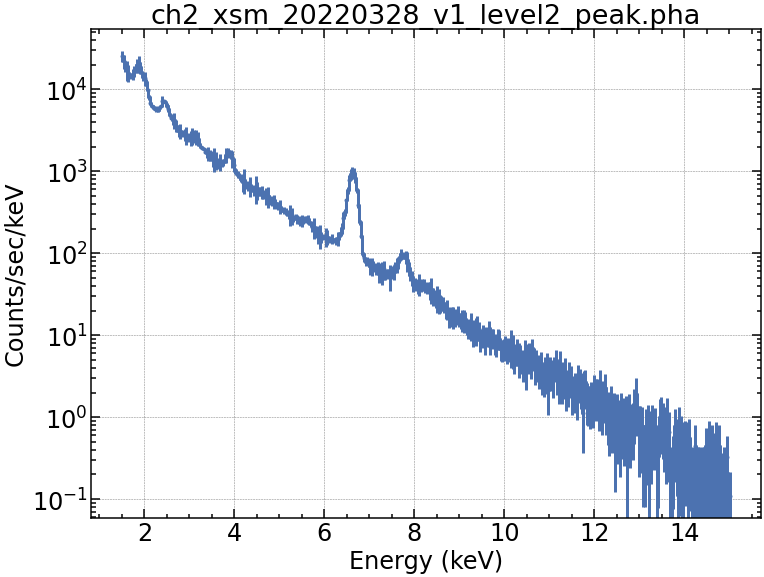

In [14]:
dplot1 = DataPHAPlot()
dplot1.prepare(pha)
dplot1.histo_prefs['linestyle'] = '-'
dplot1.plot(ylog=True,linestyle='solid')

### Model (Thermal Emission)

In [15]:
class f_vth_sherpa(model.ArithmeticModel):
    def __init__(self,name='f_vth'):
        self.temperature = model.Parameter(name,'Temperature',10,min=1,hard_min=0)
        self.em = model.Parameter(name,'EM',1,min=1e-5,hard_min=1e-49)
        model.ArithmeticModel.__init__(self, name,(self.temperature,self.em))

    def calc(self,pars,x,*args,**kwargs):
        inds = (x>1.0002920302956426) & (x<100)
        x = x[inds]
        x = np.append(x,2*x[-1]-x[-2])
        ene = x*u.keV
        temp = pars[0]*1e6*u.K
        em = pars[1]*1e49/(u.cm**5)

        y = thermal_emission(ene,temp,em)

        spec = np.zeros(len(inds))
        spec[inds] = y

        return spec

mdl = f_vth_sherpa()
ene_x = pha.get_x()
print(mdl)

f_vth
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


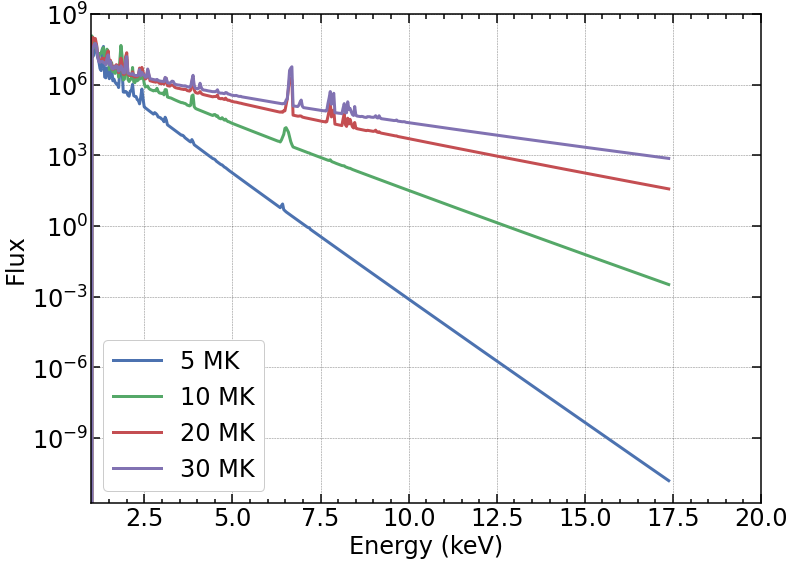

In [16]:
fig, ax = plt.subplots()
ax.semilogy(ene_x,mdl.calc([5,1],ene_x),label='5 MK')
ax.semilogy(ene_x,mdl.calc([10,1],ene_x),label='10 MK')
ax.semilogy(ene_x,mdl.calc([20,1],ene_x),label='20 MK')
ax.semilogy(ene_x,mdl.calc([30,1],ene_x),label='30 MK')
ax.legend()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Flux')
ax.set_xlim([1,20]);

In [17]:
xsm_rsp = Response1D(pha)
mdl_rsp = xsm_rsp(mdl)
print(mdl_rsp)

apply_rmf((300.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


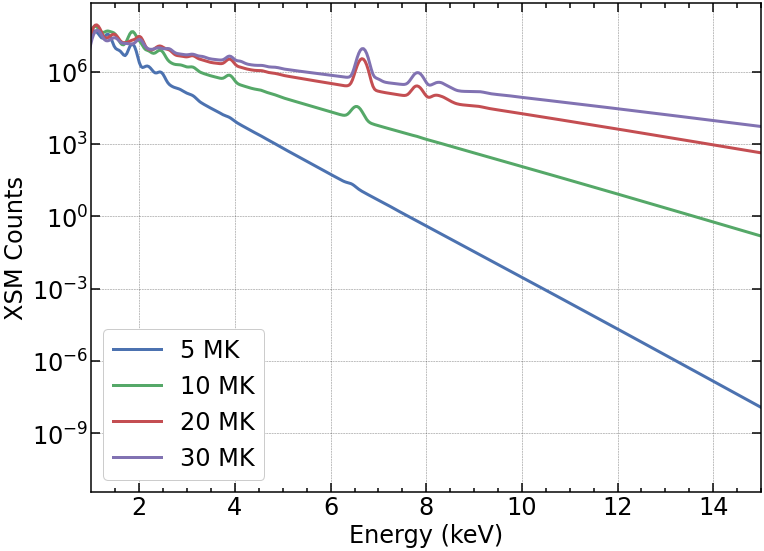

In [18]:
fig, ax = plt.subplots()
ax.semilogy(ene_x,mdl_rsp.calc([5,1],ene_x),label='5 MK')
ax.semilogy(ene_x,mdl_rsp.calc([10,1],ene_x),label='10 MK')
ax.semilogy(ene_x,mdl_rsp.calc([20,1],ene_x),label='20 MK')
ax.semilogy(ene_x,mdl_rsp.calc([30,1],ene_x),label='30 MK')
# ax.semilogy(ene_x,pha.get_y(),label='Observation')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('XSM Counts')
ax.legend()
ax.set_xlim([1,15]);

In [ ]:
#GUESS TEMPERATURE AND EM OF THE OBSERATION BY VISUAL INSPECTION
#HINT: OVERPLOT OBSERVED SPECTRUM WITH SOURCE SPECTRUM FOR DIFFERENT TEMPERATURE & EM.

### Fitting to the model

In [19]:
pha = read_pha('ch2_xsm_20220328_v1_level2_peak.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1

mdl_rsp.model.pars[0].val = 10 # Temperature
mdl_rsp.model.pars[1].val = 0.01 #EM

fi = Fit(pha,mdl_rsp)

fres = fi.fit()
print(fres)
print(f'Reduced Chi2 = {fres.statval/fres.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (17.48321847513385, 0.0060859565177202425)
statval        = 1655.429790364309
istatval       = 13825.966005758542
dstatval       = 12170.536215394233
numpoints      = 410
dof            = 408
qval           = 1.4683405291543899e-149
rstat          = 4.057425956775267
message        = successful termination
nfev           = 25
Reduced Chi2 = 4.0574


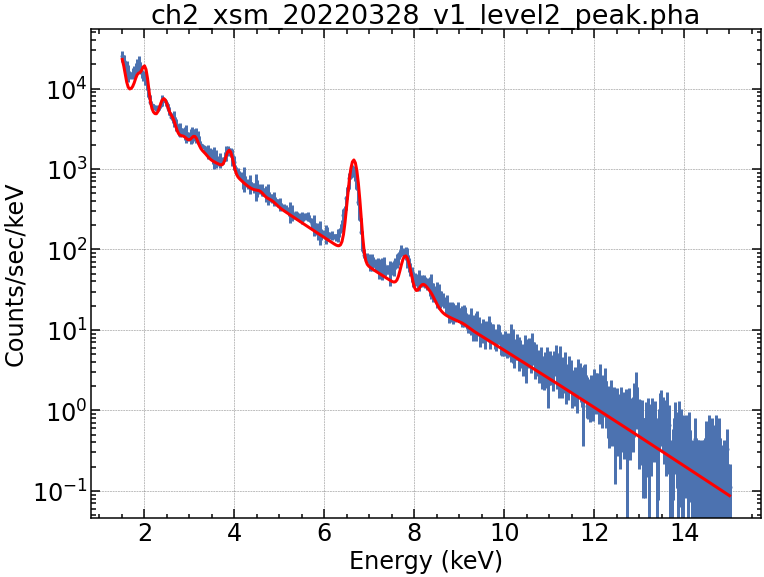

In [20]:
dplot = DataPHAPlot()
dplot.histo_prefs['linestyle'] = '-'
dplot.prepare(fi.data)
mplot = ModelPlot()
mplot.prepare(fi.data, fi.model)
dplot.plot(ylog=True)
mplot.overplot(color='red')

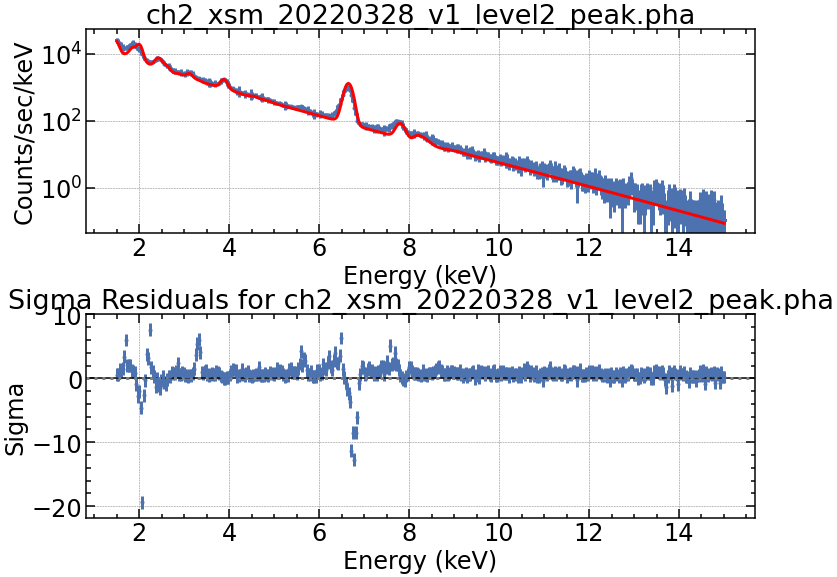

In [21]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPHAPlot()
mplot = ModelPlot()

dplot.prepare(fi.data)
dplot.histo_prefs['linestyle'] = '-'
mplot.prepare(fi.data, fi.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi.data, fi.model, fi.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

## Error Analysis

In [27]:
coverrs = fi.est_errors()
# print(coverrs)
print(coverrs.format())

coverrs.extra_output # covariance matrix

temp_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[0], ))
em_errs = fi.est_errors(parlist=(mdl_rsp.model.pars[1], ))


Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   f_vth.Temperature      17.4832   -0.0525226    0.0525226
   f_vth.EM       0.00608596 -4.09824e-05  4.09824e-05


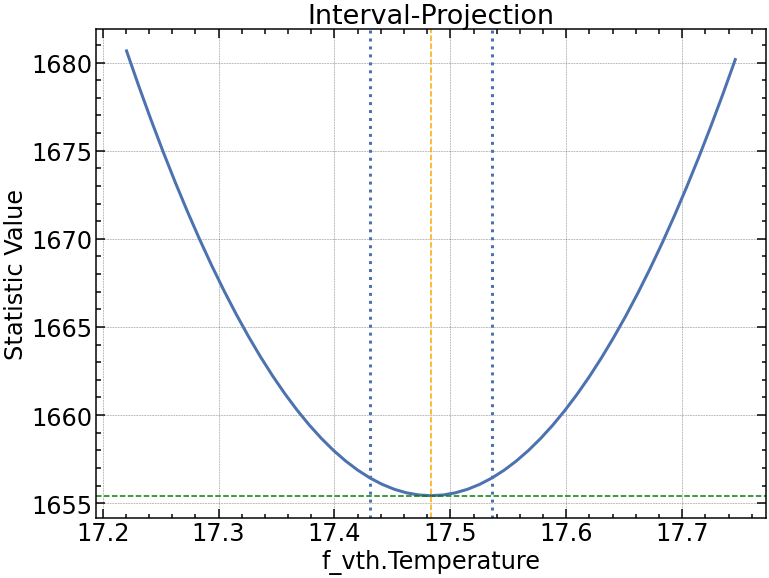

In [28]:
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=51)
iproj.calc(fi, mdl_rsp.model.pars[0])
iproj.plot()

pmin = temp_errs.parvals[0] + temp_errs.parmins[0]
pmax = temp_errs.parvals[0] + temp_errs.parmaxes[0]
iproj.vline(pmin, overplot=True, linestyle='dot')
iproj.vline(pmax, overplot=True, linestyle='dot')

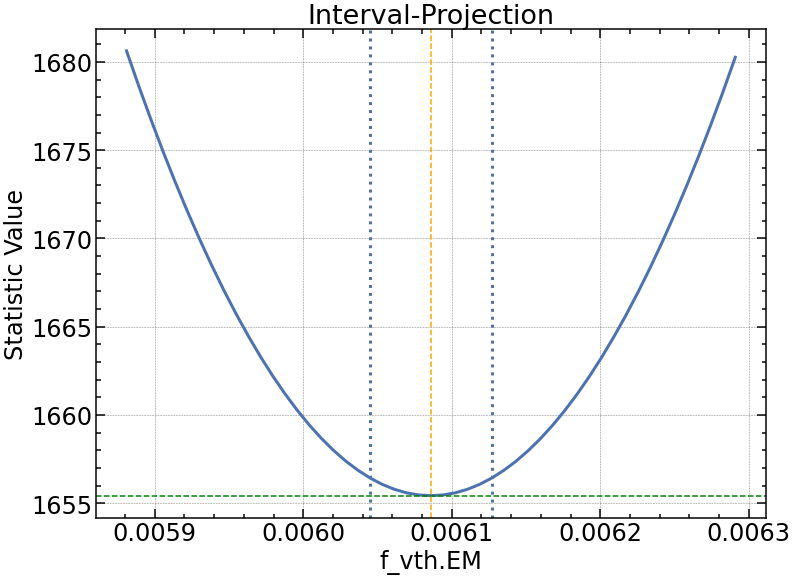

In [29]:
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=51)
iproj.calc(fi, mdl_rsp.model.pars[1])
iproj.plot()

pmin = em_errs.parvals[0] + em_errs.parmins[0]
pmax = em_errs.parvals[0] + em_errs.parmaxes[0]
iproj.vline(pmin, overplot=True, linestyle='dot')
iproj.vline(pmax, overplot=True, linestyle='dot')

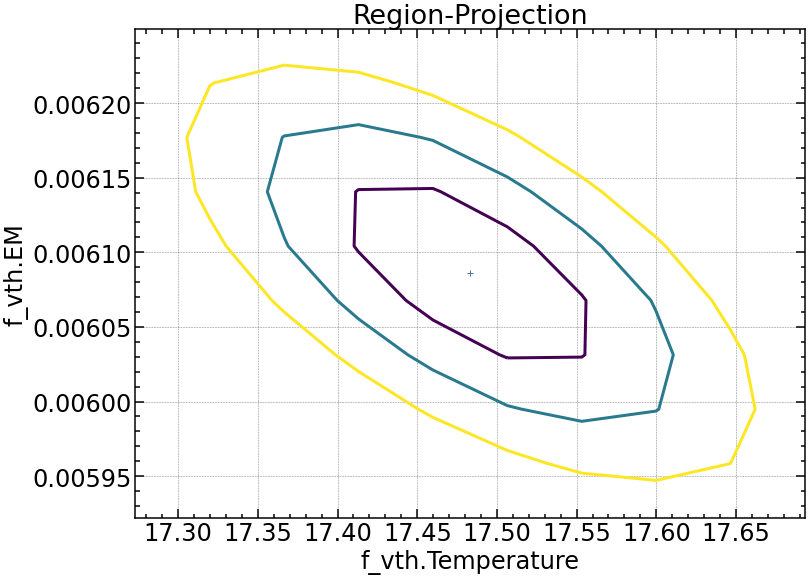

In [30]:
rproj = RegionProjection()
rproj.calc(fi, mdl_rsp.model.pars[0], mdl_rsp.model.pars[1])
rproj.contour()

## Pre-Flare

In [ ]:
# DETERMINE TEMPERATURE AND EM DURING PRE-FLARE PHASE

## Non-Thermal

In [91]:
class f_thick2_sherpa(model.ArithmeticModel):
    def __init__(self,name='f_thick2'):
        self.em = model.Parameter(name,'EM',1,min=1e-5,hard_min=1e-49)
        self.p = model.Parameter(name,'p',4,min=1,hard_min=0)
        self.eebrk = model.Parameter(name,'eebrk',150,min=1,hard_min=0)
        self.q = model.Parameter(name,'q',6,min=1,hard_min=0)
        self.eelow = model.Parameter(name,'eelow',20,min=1,hard_min=0)
        self.eehigh = model.Parameter(name,'eehigh',32000,min=1,hard_min=0)
        model.ArithmeticModel.__init__(self, name,(self.em,self.p,self.eebrk,self.q,self.eelow,self.eehigh))

    def calc(self,pars,x,*args,**kwargs):

        ene = x
        em, p, eebrk, q, eelow, eehigh = pars

        if not (eelow <= eebrk <= eehigh):
            return np.zeros(len(x))

        em = em*1e35

        y = emission.bremsstrahlung_thick_target(ene, p, eebrk, q, eelow, eehigh)*em

        return y

mdl_thick2 = f_thick2_sherpa() 
mdl_expr_thick2 = xsm_rsp(mdl_thick2)
print(mdl_expr_thick2)

mdl2 = f_vth_sherpa()
mdl_vth_rsp = xsm_rsp(mdl2)
print(mdl_vth_rsp)

apply_rmf((300.0 * f_thick2))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_thick2.EM  thawed            1        1e-05  3.40282e+38           
   f_thick2.p   thawed            4            1  3.40282e+38           
   f_thick2.eebrk thawed          150            1  3.40282e+38           
   f_thick2.q   thawed            6            1  3.40282e+38           
   f_thick2.eelow thawed           20            1  3.40282e+38           
   f_thick2.eehigh thawed        32000            1  3.40282e+38           
apply_rmf((300.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


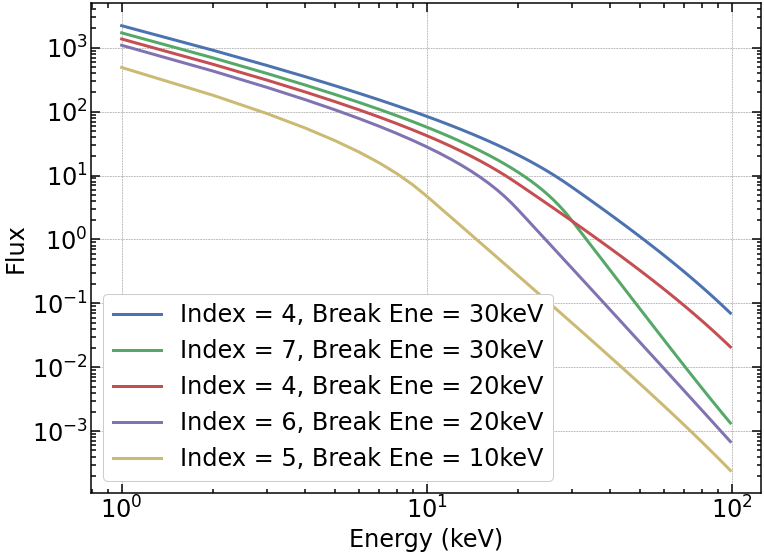

In [55]:
fig, ax = plt.subplots()
ene_xx = np.arange(1,100)
ax.semilogy(ene_xx,mdl_thick2.calc([1,4,150,6,30,32000],ene_xx),label='Index = 4, Break Ene = 30keV')
ax.semilogy(ene_xx,mdl_thick2.calc([1,7,150,6,30,32000],ene_xx),label='Index = 7, Break Ene = 30keV')
ax.semilogy(ene_xx,mdl_thick2.calc([1,4,150,6,20,32000],ene_xx),label='Index = 4, Break Ene = 20keV')
ax.semilogy(ene_xx,mdl_thick2.calc([1,6,150,6,20,32000],ene_xx),label='Index = 6, Break Ene = 20keV')
ax.semilogy(ene_xx,mdl_thick2.calc([1,5,150,6,10,32000],ene_xx),label='Index = 5, Break Ene = 10keV')
# ax.semilogy(ene_x,mdl.calc([10,1],ene_x),label='10 MK')
# ax.semilogy(ene_x,mdl.calc([20,1],ene_x),label='20 MK')
# ax.semilogy(ene_x,mdl.calc([30,1],ene_x),label='30 MK')
ax.legend()
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Flux')
# ax.set_xlim([1,20])
ax.set_xscale('log')

### Fitting

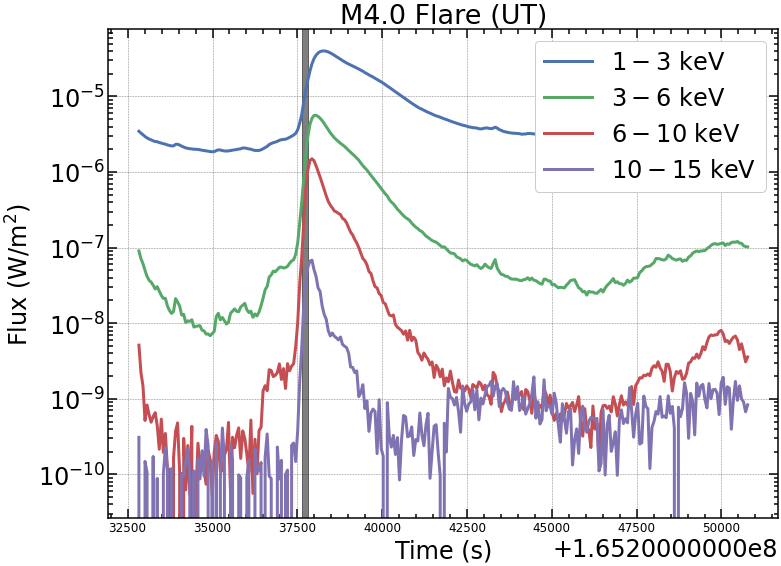

In [96]:
alltime, allflux_1_3, allcount = xsm_gen_lc(pha_file,1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc(pha_file,3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc(pha_file,6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc(pha_file,10,15)
# alltime = alltime - alltime.min()
fig, ax = plt.subplots()
ax.semilogy(alltime[600:900],allflux_1_3[600:900],label=r'$1 - 3$ keV')
ax.semilogy(alltime[600:900],allflux_3_6[600:900],label=r'$3 - 6$ keV')
ax.semilogy(alltime[600:900],allflux_6_10[600:900],label=r'$6 - 10$ keV')
ax.semilogy(alltime[600:900],allflux_10_15[600:900],label=r'$10 - 15$ keV')
ax.axvspan(alltime[680],alltime[683],alpha=0.5, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
ax.legend()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('M4.0 Flare (UT)');

In [ ]:
xsm_genspec(pha_file,alltime[680],alltime[683],'ch2_xsm_20220328_v1_level2_nonth')

#### Thermal

In [97]:
pha = read_pha('ch2_xsm_20220328_v1_level2_nonth.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1

mdl_tmp = f_vth_sherpa()
mdl_rsp = xsm_rsp(mdl_tmp)

mdl_rsp.model.pars[0].val = 10 # Temperature
mdl_rsp.model.pars[1].val = 0.01 #EM

fi_th = Fit(pha,mdl_rsp)

fres_th = fi_th.fit()
print(fres_th)
print(f'Reduced Chi2 = {fres_th.statval/fres_th.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_vth.Temperature', 'f_vth.EM')
parvals        = (17.83258074526952, 0.0016294796584079138)
statval        = 1302.850024939329
istatval       = 176634.08237119022
dstatval       = 175331.23234625088
numpoints      = 410
dof            = 408
qval           = 4.4977787040815977e-94
rstat          = 3.193259865047375
message        = successful termination
nfev           = 25
Reduced Chi2 = 3.1933


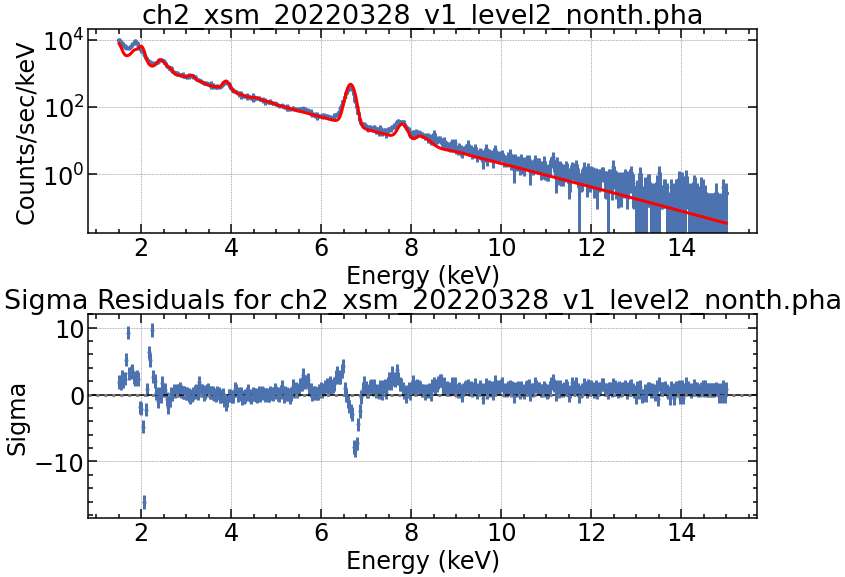

In [98]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPHAPlot()
mplot = ModelPlot()

dplot.prepare(fi_th.data)
dplot.histo_prefs['linestyle'] = '-'
mplot.prepare(fi_th.data, fi_th.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi_th.data, fi_th.model, fi_th.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

#### Fitting with Thermal + Non-Thermal

In [99]:
mdl_thick2 = f_thick2_sherpa() 
mdl_expr_thick2 = xsm_rsp(mdl_thick2)
print(mdl_expr_thick2)

mdl2 = f_vth_sherpa()
mdl_vth_rsp = xsm_rsp(mdl2)
print(mdl_vth_rsp)

mdl_expr_thick2.model.pars[5].frozen = True
mdl_expr_thick2.model.pars[2].frozen = True
mdl_expr_thick2.model.pars[3].frozen = True
mdl_expr_thick2.model.pars[1].frozen = False
mdl_expr_thick2.model.pars[4].frozen = False
mdl_expr_thick2.model.pars[0].frozen = False

mdl_expr_thick2.model.pars[4].val = 20
mdl_expr_thick2.model.pars[0].val = 10
mdl_expr_thick2.model.pars[1].val = 4

mdl_vth_rsp.model.pars[0].frozen = False
mdl_vth_rsp.model.pars[1].frozen = False

apply_rmf((300.0 * f_thick2))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_thick2.EM  thawed            1        1e-05  3.40282e+38           
   f_thick2.p   thawed            4            1  3.40282e+38           
   f_thick2.eebrk thawed          150            1  3.40282e+38           
   f_thick2.q   thawed            6            1  3.40282e+38           
   f_thick2.eelow thawed           20            1  3.40282e+38           
   f_thick2.eehigh thawed        32000            1  3.40282e+38           
apply_rmf((300.0 * f_vth))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   f_vth.Temperature thawed           10            1  3.40282e+38           
   f_vth.EM     thawed            1        1e-05  3.40282e+38           


In [100]:
pha = read_pha('ch2_xsm_20220328_v1_level2_nonth.pha',use_errors=True)
pha.set_rmf(rmf)
pha.set_analysis('energy')
pha.notice(1.5,15)

pha.staterror[pha.staterror==0] = 1
pha.syserror[pha.syserror == 0] = 1

# mdl_rsp.model.pars[0].val = 10 # Temperature
# mdl_rsp.model.pars[1].val = 0.01 #EM

fi_t2 = Fit(pha,mdl_expr_thick2+mdl_vth_rsp)

fres_t2 = fi_t2.fit()
print(fres_t2)
print(f'Reduced Chi2 = {fres_t2.statval/fres_t2.dof:.4f}')

datasets       = None
itermethodname = none
methodname     = levmar
statname       = chi2
succeeded      = True
parnames       = ('f_thick2.EM', 'f_thick2.p', 'f_thick2.eelow', 'f_vth.Temperature', 'f_vth.EM')
parvals        = (4.495345555768846, 7.401474638670116, 8.75150010190908, 16.4185603459881, 0.0014945075617384838)
statval        = 823.6510319115193
istatval       = 3242359174.144524
dstatval       = 3242358350.493492
numpoints      = 410
dof            = 405
qval           = 8.883054574243748e-31
rstat          = 2.0337062516333813
message        = successful termination
nfev           = 120
Reduced Chi2 = 2.0337


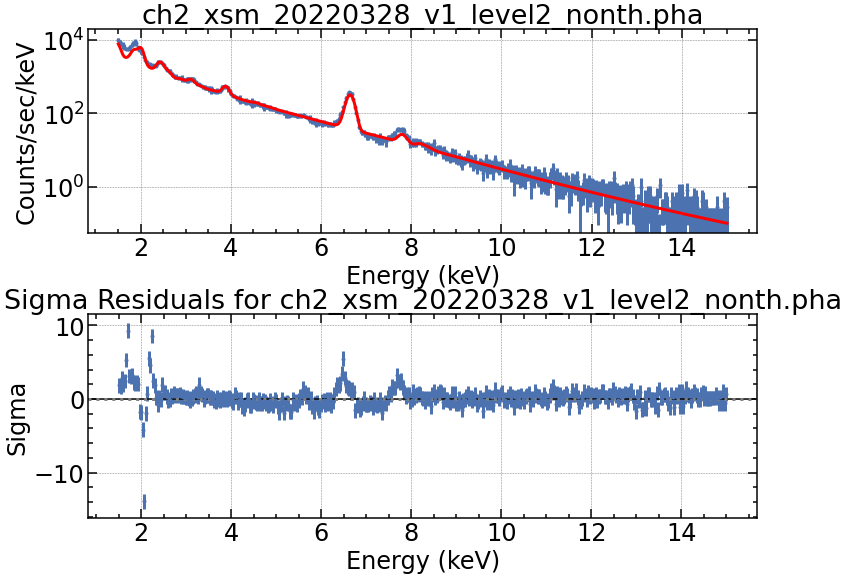

In [101]:
fplot = FitPlot()
rplot = DelchiPlot()
splot = SplitPlot()
dplot = DataPlot()
mplot = ModelPlot()

dplot.prepare(fi_t2.data)
mplot.prepare(fi_t2.data, fi_t2.model)
mplot.plot_prefs['color'] = 'red'
fplot.prepare(dplot, mplot)
splot.addplot(fplot,ylog=True)
rplot.prepare(fi_t2.data, fi_t2.model, fi_t2.stat)
splot.addplot(rplot)
# the need for a hline call is due to bug #378
rplot.hline(0, linecolor='gray', linestyle='dot', overplot=True)

#### Comparison

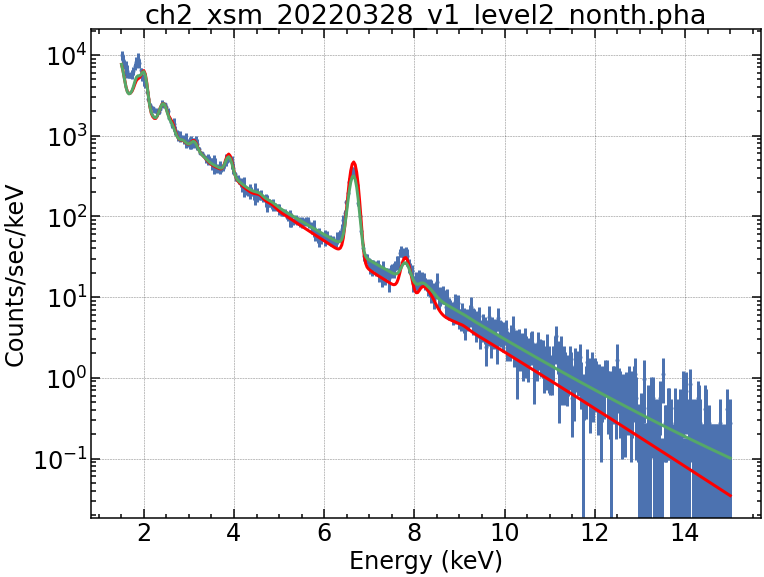

In [103]:
dplot = DataPlot()
dplot.prepare(fi_th.data)
mplot1 = ModelPlot()
mplot2 = ModelPlot()
mplot1.prepare(fi_th.data, fi_th.model)
mplot2.prepare(fi_t2.data, fi_t2.model)
dplot.plot(ylog=True)
mplot1.overplot(color='red')

mplot2.prepare(fi_t2.data, fi_t2.model)
mplot2.overplot()#(color='red')
# mplot2.plot_prefs['color'] = 'red'

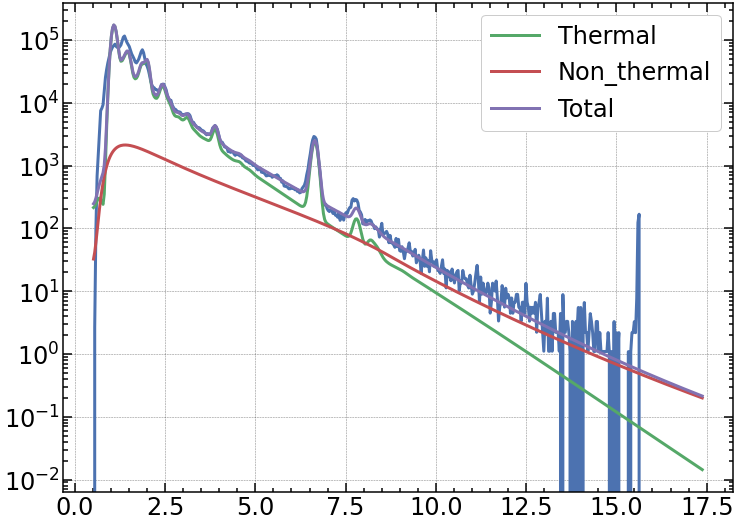

In [105]:
fig, ax = plt.subplots()
ax.semilogy(ene_x,pha.y)
ax.semilogy(ene_x,mdl_vth_rsp.calc(fres_t2.parvals[-2:],ene_x),label='Thermal')
ax.semilogy(ene_x,mdl_expr_thick2.calc([fres_t2.parvals[0],fres_t2.parvals[1],150,6,fres_t2.parvals[2],32000],ene_x),label='Non_thermal')
ax.semilogy(ene_x,mdl_vth_rsp.calc(fres_t2.parvals[-2:],ene_x)+mdl_expr_thick2.calc([fres_t2.parvals[0],fres_t2.parvals[1],150,6,fres_t2.parvals[2],32000],ene_x),label='Total')
ax.legend()

# Temporal Evolution

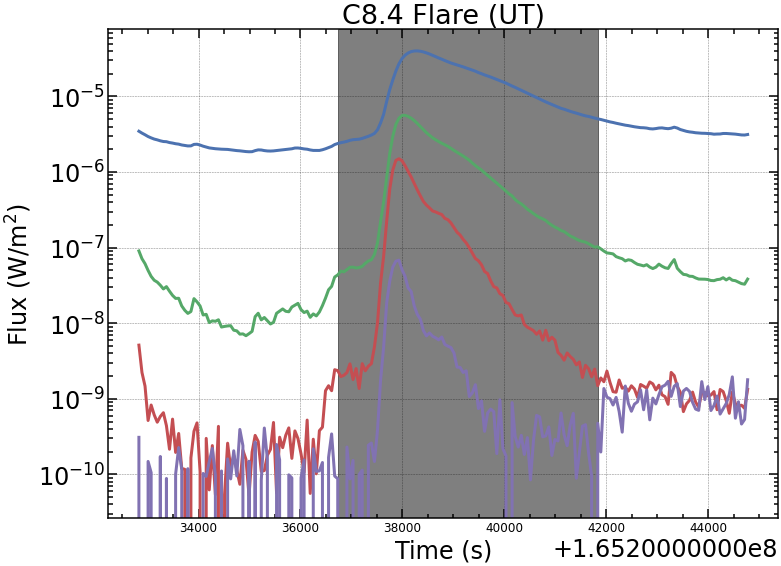

In [115]:
alltime, allflux_1_3, allcount = xsm_gen_lc(pha_file,1,3)
alltime, allflux_3_6, allcount = xsm_gen_lc(pha_file,3,6)
alltime, allflux_6_10, allcount = xsm_gen_lc(pha_file,6,10)
alltime, allflux_10_15, allcount = xsm_gen_lc(pha_file,10,15)
# alltime = alltime - alltime.min()
fig, ax = plt.subplots()
ax.semilogy(alltime[600:800],allflux_1_3[600:800],label=r'$1 - 3$ keV')
ax.semilogy(alltime[600:800],allflux_3_6[600:800],label=r'$3 - 6$ keV')
ax.semilogy(alltime[600:800],allflux_6_10[600:800],label=r'$6 - 10$ keV')
ax.semilogy(alltime[600:800],allflux_10_15[600:800],label=r'$10 - 15$ keV')
ax.axvspan(alltime[665],alltime[750],alpha=0.5, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Flux (W/m$^2$)')
# ax.legend()
ax.xaxis.set_tick_params(labelsize=12)
ax.set_title('M4.0 Flare (UT)');

In [117]:
!mkdir tmp_spectra

In [122]:
j = 0
spec_time = []
for ii in range(640,750,5):
    print(f'tmp_spectra/ch2_xsm_20220328_v1_level2_flare_{j}')
    xsm_genspec(pha_file,alltime[ii],alltime[ii+5],f'tmp_spectra/ch2_xsm_20220328_v1_level2_flare_{j}')
    j = j+1
    spec_time.append(np.mean([alltime[ii],alltime[ii+5]]))

tmp_spectra/ch2_xsm_20220328_v1_level2_flare_0
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_1
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_2
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_3
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_4
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_5
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_6
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_7
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_8
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_9
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_10
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_11
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_12
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_13
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_14
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_15
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_16
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_17
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_18
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_19
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_20
tm

In [121]:
fres_all = {}

for j in range(22):
    print(f'tmp_spectra/ch2_xsm_20220328_v1_level2_flare_{j}.pha')
    pha = read_pha(f'tmp_spectra/ch2_xsm_20220328_v1_level2_flare_{j}.pha',use_errors=True)
    pha.set_rmf(rmf)
    pha.set_analysis('energy')
    pha.notice(1.5,15)

    mdl_tmp = f_vth_sherpa()
    xsm_rsp = Response1D(pha)
    mdl_rsp_tmp = xsm_rsp(mdl_tmp)

    pha.staterror[pha.staterror==0] = 1
    pha.syserror[pha.syserror == 0] = 1

    mdl_rsp_tmp.model.pars[0].val = 10 # Temperature
    mdl_rsp_tmp.model.pars[1].val = 0.01 #EM

    fi_tmp = Fit(pha,mdl_rsp_tmp)

    fres_tmp = fi_tmp.fit()
    fres_all[j] = fres_tmp
#     print(fres_tmp)
#     print(f'Reduced Chi2 = {fres_tmp.statval/fres_tmp.dof:.4f}')

tmp_spectra/ch2_xsm_20220328_v1_level2_flare_0.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_1.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_2.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_3.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_4.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_5.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_6.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_7.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_8.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_9.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_10.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_11.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_12.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_13.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_14.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_15.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_16.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_17.pha
tmp_spectra/ch2_xsm_20220328_v1_level2_flare_18.pha
tmp_spectra/ch2_xsm_20

In [125]:
temps = []
ems = []

for j in range(22):
    temps.append(fres_all[j].parvals[0])
    ems.append(fres_all[j].parvals[1])

NameError: name 'spec_time' is not defined

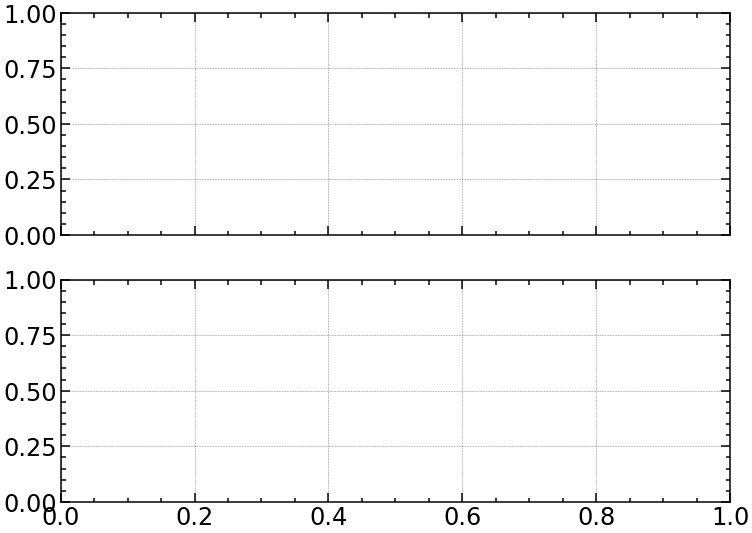

In [79]:
fig, axes = plt.subplots(2,1,sharex=True)

ax = axes[0]
ax.step(spec_time,temps,label='Temperature')
# ax.set_ylabel()

ax = axes[1]
ax.step(spec_time,ems,label='EM')
ax.xaxis.set_tick_params(labelsize=12)
